### Acknowledgment
This script was developed with guidance from Ms. Shilpi Shaw, AI Club Research Institute,
and helper code suggestions generated using ChatGPT.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q torchtuples lifelines

In [ ]:
# define the train path
TEST_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/Select_K_Best_features_test_new.csv"


In [ ]:
import pandas as pd

# load the training data
test_data = pd.read_csv(TEST_PATH)
test_data.head()

,ABHD1,AMY2A,ARL5B,ASMTL,BMS1P1,FRA10AC1,CCDC7,PEAK3,CCNJ,CD81,...,UNC93B1,ZBTB6,ZNF22,ZNF248,FLJ23404,ZNF510,ZNF676,ZNF98,Disease Free (Months),DFS_STATUS_ENCODED
0,0.1206,-0.538,-0.4877,0.9252,-2.8018,-0.8582,-0.8630,1.3354,-1.3207,0.8436,...,1.9913,-0.0029,0.2942,-2.1451,-1.6352,-0.8553,-1.1132,-0.8145,13.11,1.0
1,0.0855,-1.692,-0.3291,0.4169,-0.6546,-0.9684,-1.7453,0.2720,0.0472,-2.5123,...,0.0130,1.0599,0.3499,-0.5196,-0.2263,1.1665,0.0096,0.0456,5.19,1.0
2,-3.1493,1.163,-0.0946,1.2001,0.3905,0.5494,0.3818,-0.9768,0.2387,-0.4058,...,0.2100,-0.2163,-0.3369,-0.3830,-0.0708,0.2971,-0.5737,-0.6447,9.40,0.0
3,0.0989,-1.692,0.0611,-0.0185,-1.1171,-0.9208,0.1432,-0.1606,0.3548,-0.6095,...,-0.0466,0.9623,0.6896,-0.4969,0.1592,0.3967,-0.8014,-1.2834,4.86,1.0
4,-0.6431,-1.692,1.5867,-0.0972,1.2540,0.5406,0.5078,0.8183,1.0868,-0.3580,...,-0.7015,-0.7727,0.1924,1.1109,0.9264,-0.4374,0.4539,1.4212,1.87,1.0


In [ ]:
#Drop cols based on convergence

columns_to_drop = ['KRTAP9-4', 'OR2T2', 'OR4F17', 'SNORA36B']
test_data.drop(columns_to_drop, axis=1, inplace = True)

In [ ]:
DISEASE_MAPPER = {}
# map the disease free or recurrent status
for patient_id_, status in enumerate(test_data["DFS_STATUS_ENCODED"]):
    DISEASE_MAPPER[str(patient_id_)] = status

print(DISEASE_MAPPER)

{'0': 1.0, '1': 1.0, '2': 0.0, '3': 1.0, '4': 1.0, '5': 1.0, '6': 1.0, '7': 1.0, '8': 1.0, '9': 1.0, '10': 1.0, '11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0, '16': 0.0, '17': 0.0, '18': 1.0}


### DeepSurv Model

In [ ]:
import torch
import torch.nn as nn

# Define the DeepSurv model with additional layers and dropout
class DeepSurv(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout_prob=0.3):
        super(DeepSurv, self).__init__()
        self.layers = nn.ModuleList()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

        # Create hidden layers with dropout
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)

    def forward(self, x):
        # Pass through each hidden layer with ReLU activation and dropout
        for layer in self.layers:
            x = self.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        return self.output_layer(x)

# Function to get the loss (Negative Log-Likelihood)
def nll_loss(preds, durations, events):
    # Cox proportional hazards loss function
    hazards = preds.squeeze()
    log_hazards = torch.log(torch.cumsum(torch.exp(hazards), dim=0))
    uncensored_loss = hazards - log_hazards
    censored_loss = uncensored_loss * events
    return -torch.sum(censored_loss)

#### Load the saved model

In [ ]:
# Load the entire model
MODEL_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/DeepSurvModel/selectkbest_DeepSurv_try1.pth"
loaded_model = torch.load(MODEL_PATH)

<ipython-input-60-7da6200fed90>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(MODEL_PATH)


### Separate X and Y

In [ ]:
DEPENDENT_COLUMNS = ["Disease Free (Months)", "DFS_STATUS_ENCODED"]
GENES = [cols for cols in list(test_data.columns) if cols not in DEPENDENT_COLUMNS]

In [ ]:
# Prepare dataset
X = test_data[GENES]
y = test_data[DEPENDENT_COLUMNS]

X_test_tensor = torch.tensor(X.values, dtype=torch.float32)
y_test_duration = torch.tensor(y['Disease Free (Months)'].values, dtype=torch.float32)
y_test_event = torch.tensor(y['DFS_STATUS_ENCODED'].values, dtype=torch.float32)

In [ ]:
import numpy as np

# def compute_baseline_hazard_and_survival(model, x_test, durations_test, events_test):
#     with torch.no_grad():
#         model.eval()
#         risk_scores = model(x_test).numpy().flatten()

#     sorted_indices = np.argsort(durations_test)
#     sorted_durations = durations_test[sorted_indices]
#     sorted_events = events_test[sorted_indices]
#     sorted_risks = np.exp(risk_scores[sorted_indices])

#     unique_times, counts = np.unique(sorted_durations, return_counts=True)
#     risk_sum = np.zeros(unique_times.size)
#     event_counts = np.zeros(unique_times.size)

#     j = 0
#     for i, time in enumerate(unique_times):
#         while j < sorted_durations.size and sorted_durations[j] <= time:
#             risk_sum[i] += sorted_risks[j]
#             if sorted_events[j] == 1:
#                 event_counts[i] += 1
#             j += 1

#     cum_hazard = np.cumsum(event_counts / risk_sum)
#     baseline_survival = np.exp(-cum_hazard)

#     return unique_times, baseline_survival

def compute_baseline_hazard_and_survival(model, x_test, durations_test, events_test):
    with torch.no_grad():
        model.eval()
        # Cox-style linear predictors (a.k.a. “log-risk”)
        risk_scores = model(x_test).numpy().flatten()

    # Sort by time just so we can loop in ascending order
    sorted_indices = np.argsort(durations_test)
    sorted_durations = durations_test[sorted_indices]
    sorted_events = events_test[sorted_indices]
    sorted_risks = np.exp(risk_scores[sorted_indices])

    unique_times = np.unique(sorted_durations)
    n_times = len(unique_times)

    cum_hazard = np.zeros(n_times)
    baseline_survival = np.ones(n_times)

    for i, t in enumerate(unique_times):
        # Number of events exactly at time t
        d_i = np.sum(sorted_events[sorted_durations == t])

        # Sum of risk scores for all patients whose duration >= t
        y_i = np.sum(sorted_risks[sorted_durations >= t])

        # Baseline hazard increment
        if y_i > 0:
            hazard_i = d_i / y_i
        else:
            hazard_i = 0

        if i == 0:
            cum_hazard[i] = hazard_i
        else:
            cum_hazard[i] = cum_hazard[i - 1] + hazard_i

        baseline_survival[i] = np.exp(-cum_hazard[i])

    return unique_times, baseline_survival

def compute_survival_function_for_test(model, baseline_survival, unique_times, x_test):
    with torch.no_grad():
        risk_scores_test = model(x_test).numpy().flatten()

    survival_functions = []
    for risk_score in risk_scores_test:
        hazard = np.exp(risk_score)
        test_survival_func = baseline_survival ** hazard
        survival_functions.append(test_survival_func)

    return unique_times, survival_functions


# Compute baseline survival function
unique_times, baseline_survival = compute_baseline_hazard_and_survival(loaded_model, X_test_tensor, y_test_duration.numpy(), y_test_event.numpy())

# Get survival functions for test data
time_points, survival_funcs = compute_survival_function_for_test(loaded_model, baseline_survival, unique_times, X_test_tensor)

In [ ]:
from tabulate import tabulate

# Function to print survival functions for each patient in a table format
def print_survival_table(unique_times, survival_funcs):
    # Prepare the header where the first column is "Time" and the remaining are patient columns
    header = ["Time (Months)"] + [f"Patient {i}" for i in range(len(survival_funcs))]

    # Prepare the data rows: Each row corresponds to a time point, and columns correspond to survival probabilities for each patient
    rows = []
    for i, time in enumerate(unique_times):
        row = [f"{time:.2f}"] + [f"{survival_funcs[p][i]:.4f}" for p in range(len(survival_funcs))]
        rows.append(row)

    # Print the table with tabulate
    print(tabulate(rows, headers=header, tablefmt="grid"))

# Print survival functions for each patient
print_survival_table(time_points, survival_funcs)

+-----------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|   Time (Months) |   Patient 0 |   Patient 1 |   Patient 2 |   Patient 3 |   Patient 4 |   Patient 5 |   Patient 6 |   Patient 7 |   Patient 8 |   Patient 9 |   Patient 10 |   Patient 11 |   Patient 12 |   Patient 13 |   Patient 14 |   Patient 15 |   Patient 16 |   Patient 17 |   Patient 18 |
+=================+=============+=============+=============+=============+=============+=============+=============+=============+=============+=============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
|            1.12 |      0.9473 |      0.951  |      0.9543 |      0.9522 |      0.9455 |      0.9475 |      0.9374

In [ ]:
import pandas as pd
import numpy as np

# Function to convert survival functions into a pandas DataFrame
def survival_to_dataframe(unique_times, survival_funcs):
    df = pd.DataFrame(survival_funcs, columns=unique_times)
    df.index.name = 'Patient'
    df.columns.name = 'Time (Months)'

    # Transpose so that time is in rows and patients are in columns
    df_transposed = df.T
    return df_transposed


# Convert the survival functions into a DataFrame
survival_df = survival_to_dataframe(time_points, survival_funcs)

# Sort by index (patient index)
survival_df_sorted = survival_df.sort_index()

# Display the first few rows of survival probabilities
print(survival_df_sorted.head())

Patient              0         1         2         3         4         5   \
Time (Months)                                                               
1.12           0.947279  0.950971  0.954263  0.952205  0.945487  0.947495   
1.87           0.894344  0.901546  0.907992  0.903960  0.890861  0.894765   
2.20           0.841301  0.851808  0.861252  0.855341  0.836235  0.841914   
2.37           0.788102  0.801696  0.813971  0.806282  0.781569  0.788893   
2.69           0.735152  0.751579  0.766480  0.757138  0.727289  0.736106   

Patient              6         7         8         9         10        11  \
Time (Months)                                                               
1.12           0.937351  0.950867  0.942239  0.948206  0.955387  0.945834   
1.87           0.875129  0.901343  0.884563  0.896151  0.910199  0.891536   
2.20           0.813494  0.851512  0.827105  0.843934  0.864494  0.837216   
2.37           0.752431  0.801312  0.769835  0.791501  0.818196  0.782833  

In [ ]:
import random
import matplotlib.colors as mcolors

def generate_interpolation(index, intervals, survival_probs):
    time_occured = test_data["Disease Free (Months)"].to_list()
    intersection = np.interp(time_occured[index], intervals, survival_probs)
    return intersection


def generate_random_colors(n):
    # Get a list of all matplotlib color names
    color_names = list(mcolors.CSS4_COLORS.keys())

    # Check if the requested number of colors is greater than the available colors
    if n > len(color_names):
        raise ValueError(f"Requested number of colors exceeds available colors ({len(color_names)}).")

    # Select n random colors
    random_colors = random.sample(color_names, n)

    return random_colors

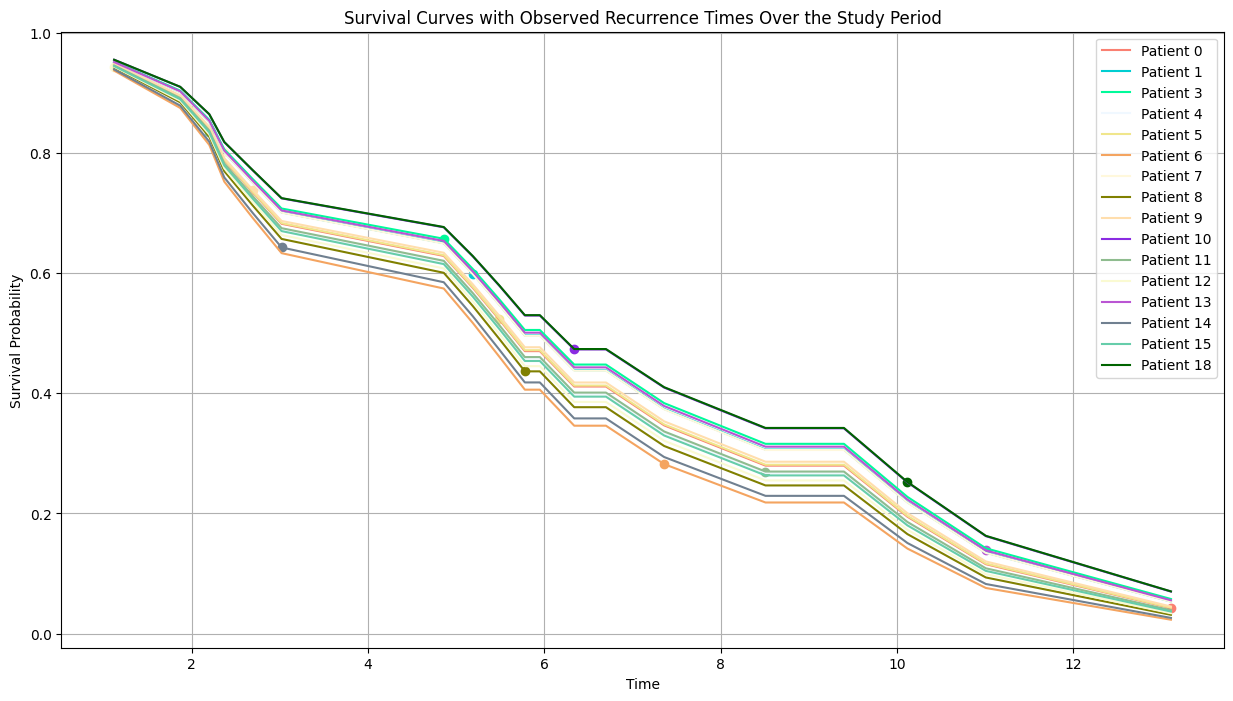

In [ ]:
# Visualize all Patients with DFS_ENCODED_STATUS = 1

import matplotlib.pyplot as plt

time_occured = test_data["Disease Free (Months)"].to_list()
color_palatte = generate_random_colors(test_data.shape[0])

# Plot survival curves for test data
plt.figure(figsize = (15,8))
for index, survival_func in enumerate(survival_funcs):
    if int(DISEASE_MAPPER[str(index)]) == 0:
        continue
    plt.plot(time_points, survival_func, label=f"Patient {index}", color = color_palatte[index])
    plt.scatter(x = time_occured[index], y = generate_interpolation(index, time_points, survival_func), color = color_palatte[index])
plt.grid(True)
plt.xlabel("Time")
plt.ylabel('Survival Probability')
plt.title("Survival Curves with Observed Recurrence Times Over the Study Period")
plt.legend(loc='best')
plt.show()

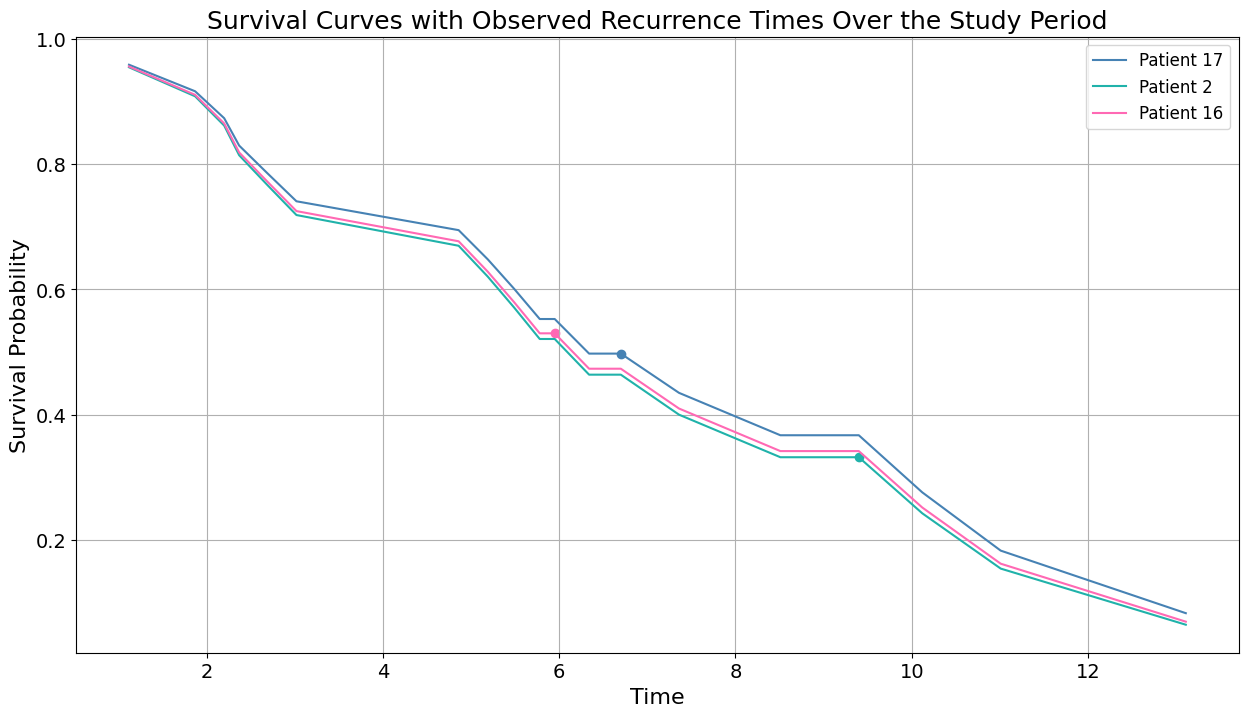

In [ ]:
# Visualize randome 3 Patients with DFS_ENCODED_STATUS = 0

import matplotlib.pyplot as plt

time_occured = test_data["Disease Free (Months)"].to_list()
color_palatte = generate_random_colors(test_data.shape[0])

# Filter test_data to get indices of patients with dfs_status_encoded == 0
filtered_indices = test_data[test_data["DFS_STATUS_ENCODED"] == 0].index

# Check if we have enough patients to select 3, and pick random indices accordingly
num_patients_to_select = min(3, len(filtered_indices))
selected_indices = random.sample(list(filtered_indices), num_patients_to_select)


# Plot survival curves for test data
plt.figure(figsize = (15,8))
for i, index in enumerate(selected_indices):
    survival_func = survival_funcs[index]
    plt.plot(time_points, survival_func, label=f"Patient {index}", color = color_palatte[i])
    plt.scatter(x = time_occured[index], y = generate_interpolation(index, time_points, survival_func), color = color_palatte[i])

# Customize axis tick and label font sizes
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size

# Customize axis labels and title font sizes
plt.xlabel("Time", fontsize=16)
plt.ylabel("Survival Probability", fontsize=16)
plt.title("Survival Curves with Observed Recurrence Times Over the Study Period", fontsize=18)

plt.legend(loc="best", fontsize=12)  # Adjust legend font size
plt.grid(True)
plt.show()

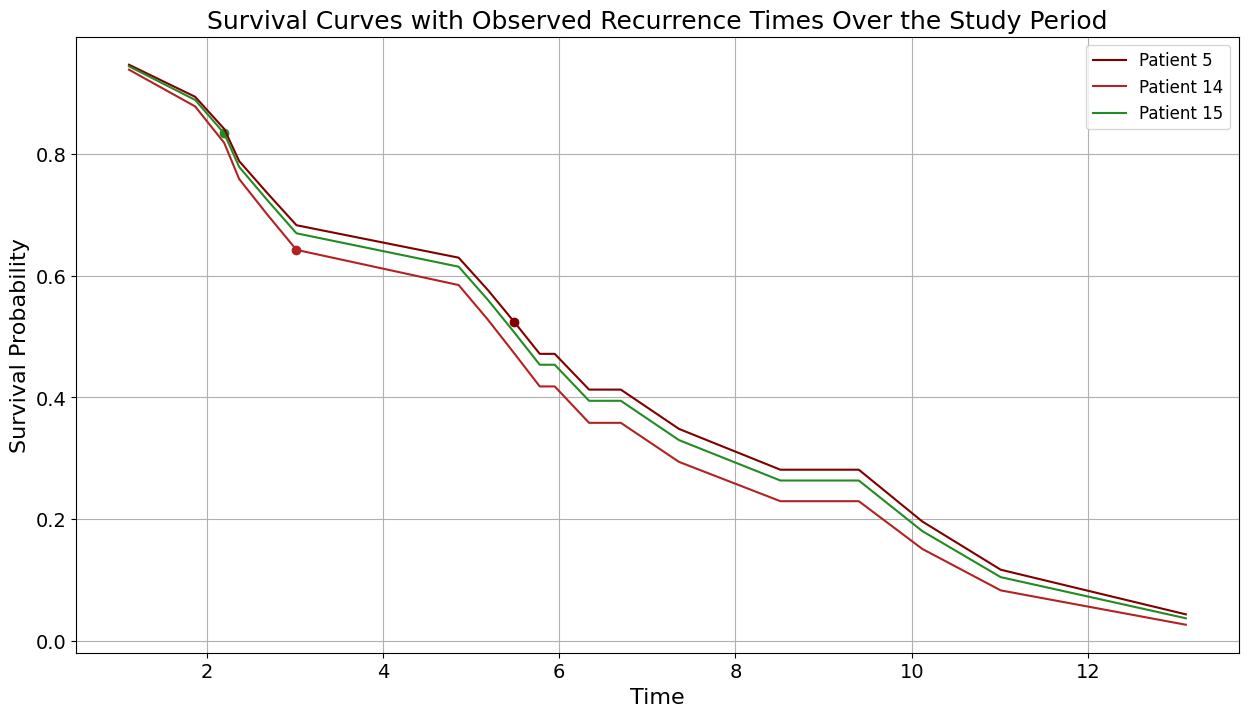

In [ ]:
# Visualization of Patients with selected pateint ids and with DFS_STATUS_ENCODED = 1

import matplotlib.pyplot as plt

# Selected patient IDs
selected_patient_ids = [5, 14, 15]

# Ensure the selected patients exist in the test_data and have DFS_STATUS_ENCODED == 1
filtered_data = test_data[(test_data["DFS_STATUS_ENCODED"] == 1) & (test_data.index.isin(selected_patient_ids))]

# Filter indices based on the selected patient IDs
selected_indices = filtered_data.index

# Time occurred for the selected patients
time_occured = test_data.loc[selected_indices, "Disease Free (Months)"].to_list()


color_palatte = generate_random_colors(test_data.shape[0])


# Plot survival curves for test data
plt.figure(figsize = (15,8))
for i, index in enumerate(selected_indices):
    survival_func = survival_funcs[index]
    plt.plot(time_points, survival_func, label=f"Patient {index}", color = color_palatte[i])
    plt.scatter(x = time_occured[i], y = generate_interpolation(index, time_points, survival_func), color = color_palatte[i])
# Customize axis tick and label font sizes
plt.xticks(fontsize=14)  # Adjust x-axis tick font size
plt.yticks(fontsize=14)  # Adjust y-axis tick font size

# Customize axis labels and title font sizes
plt.xlabel("Time", fontsize=16)
plt.ylabel("Survival Probability", fontsize=16)
plt.title("Survival Curves with Observed Recurrence Times Over the Study Period", fontsize=18)

plt.legend(loc="best", fontsize=12)  # Adjust legend font size
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

TRAIN_PATH = "/content/drive/Shareddrives/1:1_Krish_Nachnani/2024/Glioblastoma Multiforme -genome data/csv/Select_K_Best_features_train_new.csv"

# load the training data
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()

# Prepare dataset
X = train_data[GENES]
y = train_data[DEPENDENT_COLUMNS]

X_train_tensor = torch.tensor(X.values, dtype=torch.float32)
y_train_duration = torch.tensor(y['Disease Free (Months)'].values, dtype=torch.float32)
y_train_event = torch.tensor(y['DFS_STATUS_ENCODED'].values, dtype=torch.float32)

X.shape

(73, 46)

In [ ]:
import numpy as np


def compute_baseline_hazard_and_survival(model, x_test, durations_test, events_test):
    with torch.no_grad():
        model.eval()
        # Cox-style linear predictors (a.k.a. “log-risk”)
        risk_scores = model(x_test).numpy().flatten()

    # Sort by time just so we can loop in ascending order
    sorted_indices = np.argsort(durations_test)
    sorted_durations = durations_test[sorted_indices]
    sorted_events = events_test[sorted_indices]
    sorted_risks = np.exp(risk_scores[sorted_indices])

    unique_times = np.unique(sorted_durations)
    n_times = len(unique_times)

    cum_hazard = np.zeros(n_times)
    baseline_survival = np.ones(n_times)

    for i, t in enumerate(unique_times):
        # Number of events exactly at time t
        d_i = np.sum(sorted_events[sorted_durations == t])

        # Sum of risk scores for all patients whose duration >= t
        y_i = np.sum(sorted_risks[sorted_durations >= t])

        # Baseline hazard increment
        if y_i > 0:
            hazard_i = d_i / y_i
        else:
            hazard_i = 0

        if i == 0:
            cum_hazard[i] = hazard_i
        else:
            cum_hazard[i] = cum_hazard[i - 1] + hazard_i

        baseline_survival[i] = np.exp(-cum_hazard[i])

    return unique_times, baseline_survival

def compute_survival_function_for_test(model, baseline_survival, unique_times, x_test):
    with torch.no_grad():
        risk_scores_test = model(x_test).numpy().flatten()

    survival_functions = []
    for risk_score in risk_scores_test:
        hazard = np.exp(risk_score)
        test_survival_func = baseline_survival ** hazard
        survival_functions.append(test_survival_func)

    return unique_times, survival_functions


# Compute baseline survival function
unique_times, baseline_survival = compute_baseline_hazard_and_survival(loaded_model, X_train_tensor, y_train_duration.numpy(), y_train_event.numpy())

# Get survival functions for test data
time_points, survival_funcs = compute_survival_function_for_test(loaded_model, baseline_survival, unique_times, X_train_tensor)

# Convert survival_funcs to a DataFrame
survival_funcs_df = pd.DataFrame(survival_funcs).T

# Insert time_points as the first column
survival_funcs_df.insert(0, "Time Points", time_points)

# inspect the DataFrame
print(survival_funcs_df.shape)
print(time_points.shape)
print(survival_funcs_df.head())

# Save to Excel
output_path = "DeepSurv_SKB_train_survival.xlsx"
survival_funcs_df.to_excel(output_path, index=False)


(69, 74)
(69,)
   Time Points         0         1         2         3         4         5  \
0         0.20  0.987146  0.984763  0.987635  0.986902  0.988643  0.988140   
1         0.43  0.987146  0.984763  0.987635  0.986902  0.988643  0.988140   
2         0.85  0.974105  0.969342  0.975083  0.973617  0.977103  0.976095   
3         1.22  0.974105  0.969342  0.975083  0.973617  0.977103  0.976095   
4         1.58  0.974105  0.969342  0.975083  0.973617  0.977103  0.976095   

          6         7         8  ...        63        64        65        66  \
0  0.987147  0.988584  0.987814  ...  0.989571  0.987722  0.977891  0.987301   
1  0.987147  0.988584  0.987814  ...  0.989571  0.987722  0.977891  0.987301   
2  0.974107  0.976985  0.975443  ...  0.978965  0.975258  0.955673  0.974415   
3  0.974107  0.976985  0.975443  ...  0.978965  0.975258  0.955673  0.974415   
4  0.974107  0.976985  0.975443  ...  0.978965  0.975258  0.955673  0.974415   

         67        68        69    